<a href="https://colab.research.google.com/github/srushtinandu/ML-Project/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Libraries
We install transformers library that will help us in our neual network framework. 

In [ ]:
pip install transformers

     |████████████████████████████████| 2.1MB 6.8MB/s 
     |████████████████████████████████| 901kB 37.2MB/s 
     |████████████████████████████████| 3.3MB 36.4MB/s 


## Importing packages and defining constants
The packages we will use include matplotlib, pandas, PyTorch, which is our general-purpose deep learning library of choice

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import pandas as pd

## Loading the dataset
We load the dataset, consisting of 12.8k news statements and other fields, and put them in a dataframe. 

In [ ]:
url = 'https://raw.githubusercontent.com/srushtinandu/NLP-Project/main/data/train.tsv'
train_data = pd.read_csv(url, sep = '\t')
train_data.columns=['ID', 'Label', 'Statement', 'subject(s)', 'speaker', 'speaker\'s job', 'state info', 'party affiliation', 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts', 'context (venue / location of the speech or statement)']
train_data.head()

,ID,Label,Statement,subject(s),speaker,speaker's job,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,context (venue / location of the speech or statement)
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


We drop the unwanted columns from the dataset

In [ ]:
train_data = train_data.drop(columns=['ID', 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts'])

Next, we check for class imbalance, and the total counts of all classes

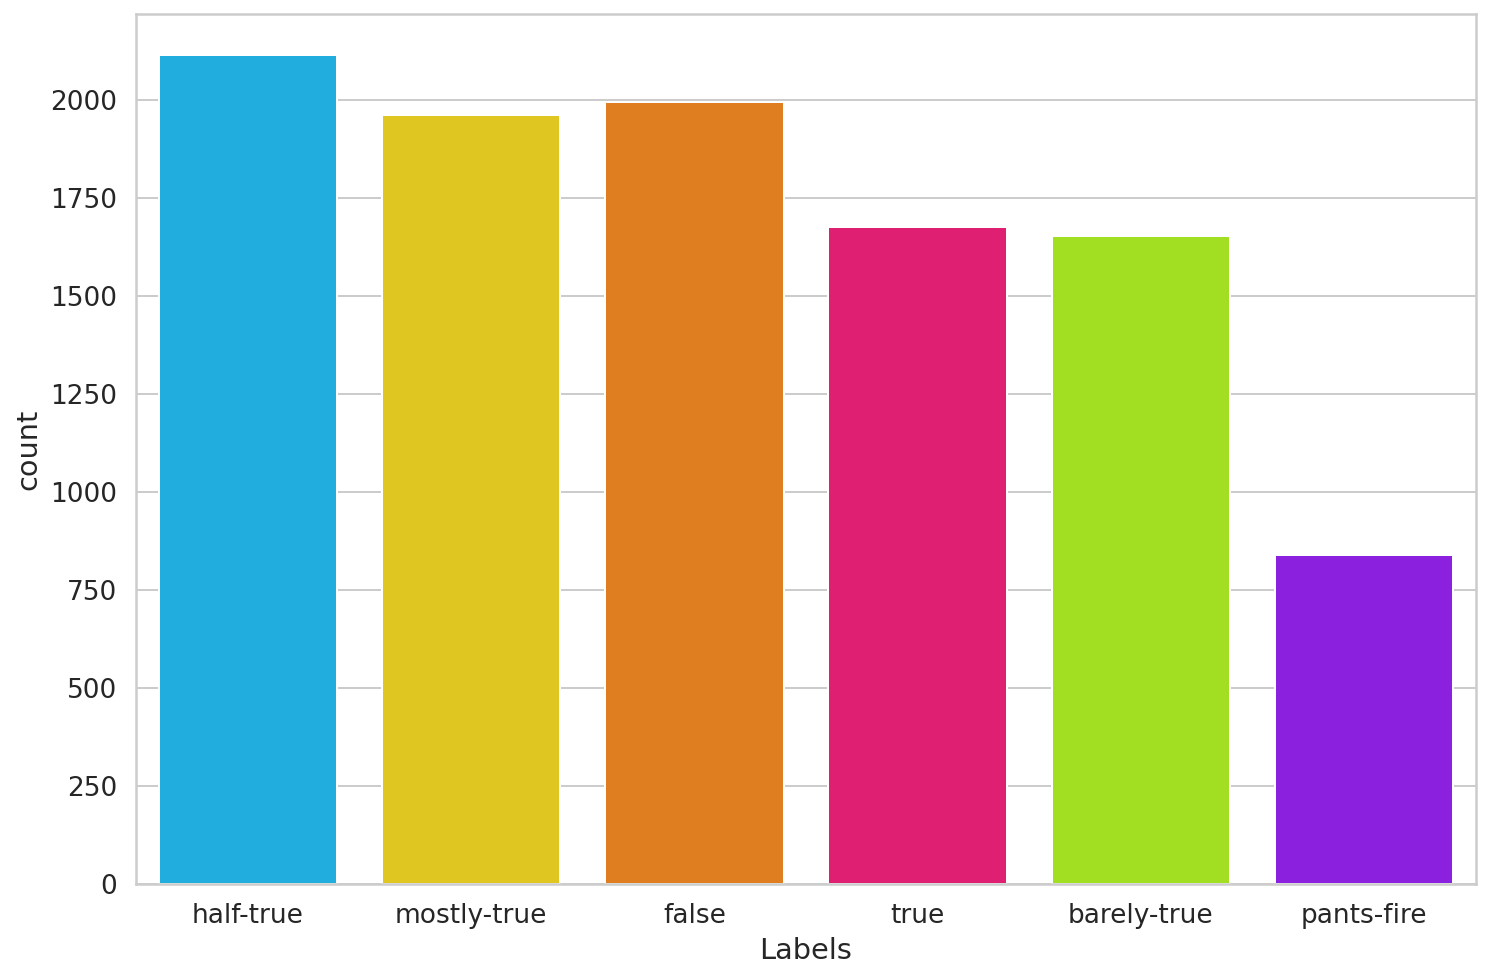

In [ ]:
sns.countplot(x=train_data.Label)
plt.xlabel('Labels')
plt.show()

We want to convert the 6-class classification into a binary classification model, so we change the labels to true/false


In [ ]:
def to_label(label):
  if label == 'mostly-true' or label == 'half-true':
    return 'true'
  elif label == 'pants-fire' or label == 'barely-true':
    return 'false'
  else:
    return label

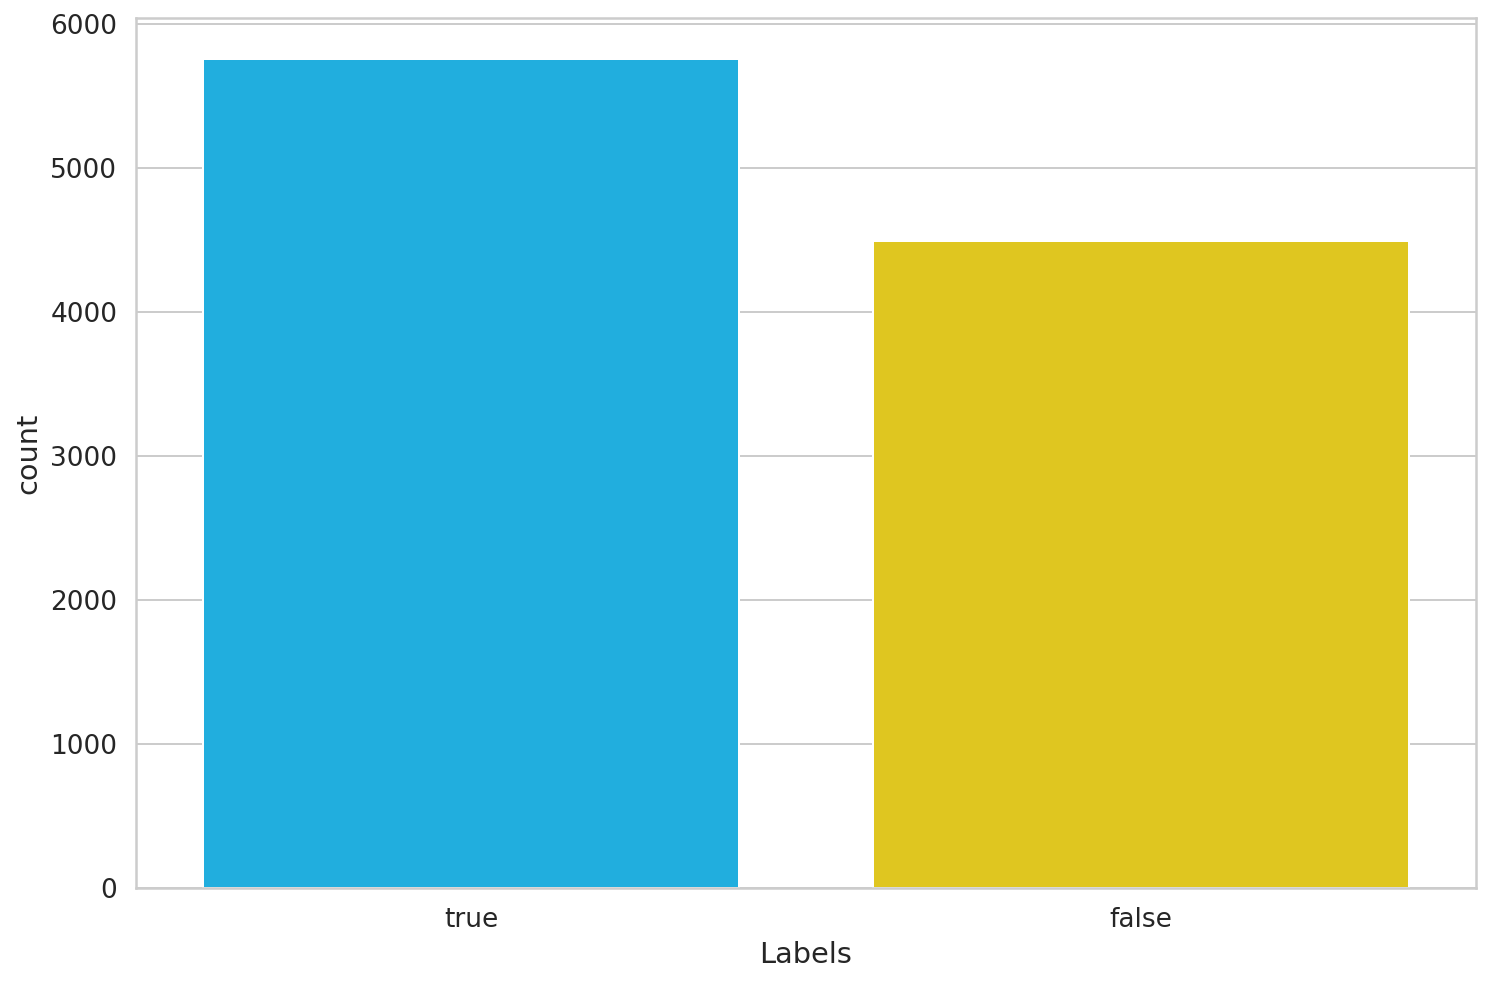

In [ ]:
train_data['Label'] = train_data.Label.apply(to_label)
sns.countplot(x=train_data.Label)
plt.xlabel('Labels')
plt.show()

In [ ]:
train_data.replace(['true', 'false'], [1,0], inplace=True)

In [ ]:
class_names = ['true','false']

## Loading a pre-trained BertTokenizer


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

## Choosing sequence length
We store the length of each statement in our dataset to determine the maximum length. 

In [ ]:
token_lens = []
for txt in train_data.Statement:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))


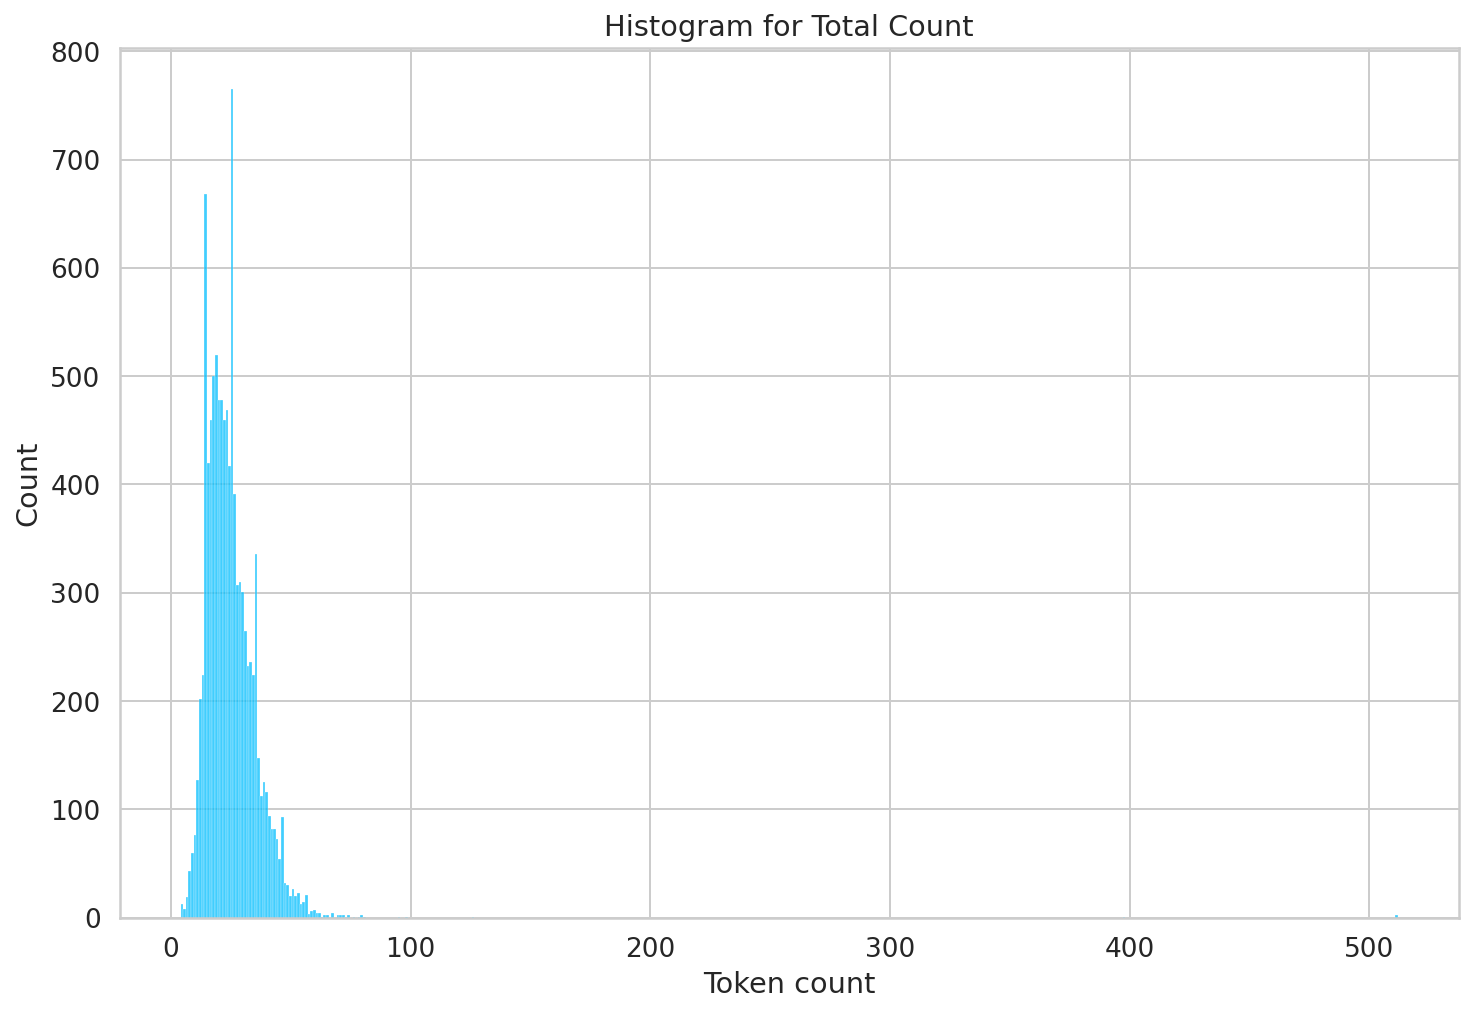

In [ ]:
sns.histplot(token_lens)
plt.title("Histogram for Total Count")
plt.xlabel('Token count')
plt.show()

Defining some constants

In [ ]:
MAX_LEN = 100 #defining the maximum length of the statements
BATCH_SIZE = 16
EPOCHS = 4

## Create a PyTorch dataset

In [ ]:
class GPReviewDataset(Dataset):
  def __init__(self, statements, labels, tokenizer, max_len):
    self.statements = statements
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.statements)
  def __getitem__(self, item):
    statement = str(self.statements[item])
    label = self.labels[item]
    encoding = self.tokenizer.encode_plus(
      statement,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length = True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'statement_text': statement,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

We need to create data loaders, and hence we define a method for the same

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    statements=df.Statement.to_numpy(),
    labels=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  #print(df.Label.to_numpy())
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

# Creating Data Loader

In [ ]:
train_data_loader = create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['statement_text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Building a Fake News Classifier

In [ ]:
class FakeNewsClassifier(nn.Module):

  def __init__(self, n_classes):
    super(FakeNewsClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = FakeNewsClassifier(2)
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape)

torch.Size([16, 100])
torch.Size([16, 100])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.7834, 0.2166],
        [0.7021, 0.2979],
        [0.6737, 0.3263],
        [0.7595, 0.2405],
        [0.6847, 0.3153],
        [0.7378, 0.2622],
        [0.7573, 0.2427],
        [0.7523, 0.2477],
        [0.6533, 0.3467],
        [0.6782, 0.3218],
        [0.6362, 0.3638],
        [0.5565, 0.4435],
        [0.8531, 0.1469],
        [0.5836, 0.4164],
        [0.7383, 0.2617],
        [0.6776, 0.3224]], grad_fn=<SoftmaxBackward>)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

## Training the Classifier


In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for itr, d in enumerate(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["labels"].to(device)
    #print(d['statement_text'])
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    if itr%20 == 0:
      completed = 16 * itr
      print(f"Train Epoch: {epoch+1} [{completed}/10239 ({int(completed * 100/10239)}%)]   Loss: {loss: .6f}")

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
url = 'https://raw.githubusercontent.com/srushtinandu/NLP-Project/main/data/valid.tsv'
valid_data = pd.read_csv(url, sep = '\t')
valid_data.columns=['ID', 'Label', 'Statement', 'subject(s)', 'speaker', 'speaker\'s job', 'state info', 'party affiliation', 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts', 'context (venue / location of the speech or statement)']


In [ ]:
valid_data = valid_data.drop(columns=['ID', 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts'])
def to_label(label):
  if label == 'mostly-true' or label == 'half-true':
    return 'true'
  elif label == 'pants-fire' or label == 'barely-true':
    return 'false'
  else:
    return label
valid_data['Label'] = valid_data.Label.apply(to_label)
valid_data.replace(['true', 'false'], [1,0], inplace=True)



In [ ]:
val_data_loader = create_data_loader(valid_data, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(train_data)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device, 
    len(valid_data)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  torch.save(model.state_dict(), f'model_epoch_{epoch+1}.bin')
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Train Epoch: 1 [0/10239 (0%)]   Loss:  1.003564
Train Epoch: 1 [320/10239 (3%)]   Loss:  0.775357
Train Epoch: 1 [640/10239 (6%)]   Loss:  0.795985
Train Epoch: 1 [960/10239 (9%)]   Loss:  0.756188
Train Epoch: 1 [1280/10239 (12%)]   Loss:  0.656160
Train Epoch: 1 [1600/10239 (15%)]   Loss:  0.798137
Train Epoch: 1 [1920/10239 (18%)]   Loss:  0.680297
Train Epoch: 1 [2240/10239 (21%)]   Loss:  0.604399
Train Epoch: 1 [2560/10239 (25%)]   Loss:  0.599178
Train Epoch: 1 [2880/10239 (28%)]   Loss:  0.826887
Train Epoch: 1 [3200/10239 (31%)]   Loss:  0.702440
Train Epoch: 1 [3520/10239 (34%)]   Loss:  0.534140
Train Epoch: 1 [3840/10239 (37%)]   Loss:  0.785973
Train Epoch: 1 [4160/10239 (40%)]   Loss:  0.624301
Train Epoch: 1 [4480/10239 (43%)]   Loss:  0.743261
Train Epoch: 1 [4800/10239 (46%)]   Loss:  0.864429
Train Epoch: 1 [5120/10239 (50%)]   Loss:  0.581642
Train Epoch: 1 [5440/10239 (53%)]   Loss:  0.693608
Train Epoch: 1 [5760/10239 (56%)]   Loss:  0.559447
Train Epoch: 1 [6080/1

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6597052871445079 accuracy 0.6157443491816056

Epoch 2/4
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train Epoch: 2 [0/10239 (0%)]   Loss:  0.635108
Train Epoch: 2 [320/10239 (3%)]   Loss:  0.682796
Train Epoch: 2 [640/10239 (6%)]   Loss:  0.632116
Train Epoch: 2 [960/10239 (9%)]   Loss:  0.621933
Train Epoch: 2 [1280/10239 (12%)]   Loss:  0.805062
Train Epoch: 2 [1600/10239 (15%)]   Loss:  0.755184
Train Epoch: 2 [1920/10239 (18%)]   Loss:  0.953542
Train Epoch: 2 [2240/10239 (21%)]   Loss:  0.515485
Train Epoch: 2 [2560/10239 (25%)]   Loss:  0.558014
Train Epoch: 2 [2880/10239 (28%)]   Loss:  0.707031
Train Epoch: 2 [3200/10239 (31%)]   Loss:  0.580162
Train Epoch: 2 [3520/10239 (34%)]   Loss:  0.557476
Train Epoch: 2 [3840/10239 (37%)]   Loss:  0.645667
Train Epoch: 2 [4160/10239 (40%)]   Loss:  0.758664
Train Epoch: 2 [4480/10239 (43%)]   Loss:  0.670984
Train Epoch: 2 [4800/10239 (46%)]   Loss:  0.667659
Train Epoch: 2 [5120/10239 (50%)]   Loss:  0.572579
Train Epoch: 2 [5440/10239 (53%)]   Loss:  0.658610
Train Epoch: 2 [5760/10239 (56%)]   Loss:  0.578889
Train Epoch: 2 [6080/1

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.7085591455300649 accuracy 0.6219797349961029

Epoch 3/4
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train Epoch: 3 [0/10239 (0%)]   Loss:  0.478388
Train Epoch: 3 [320/10239 (3%)]   Loss:  0.748518
Train Epoch: 3 [640/10239 (6%)]   Loss:  0.359700
Train Epoch: 3 [960/10239 (9%)]   Loss:  0.770967
Train Epoch: 3 [1280/10239 (12%)]   Loss:  0.666473
Train Epoch: 3 [1600/10239 (15%)]   Loss:  0.402149
Train Epoch: 3 [1920/10239 (18%)]   Loss:  1.344512
Train Epoch: 3 [2240/10239 (21%)]   Loss:  0.472343
Train Epoch: 3 [2560/10239 (25%)]   Loss:  0.361205
Train Epoch: 3 [2880/10239 (28%)]   Loss:  0.351386
Train Epoch: 3 [3200/10239 (31%)]   Loss:  0.240876
Train Epoch: 3 [3520/10239 (34%)]   Loss:  0.425523
Train Epoch: 3 [3840/10239 (37%)]   Loss:  0.362233
Train Epoch: 3 [4160/10239 (40%)]   Loss:  0.582904
Train Epoch: 3 [4480/10239 (43%)]   Loss:  0.575506
Train Epoch: 3 [4800/10239 (46%)]   Loss:  0.672647
Train Epoch: 3 [5120/10239 (50%)]   Loss:  0.318021
Train Epoch: 3 [5440/10239 (53%)]   Loss:  0.678841
Train Epoch: 3 [5760/10239 (56%)]   Loss:  0.571241
Train Epoch: 3 [6080/1

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.8260519287468474 accuracy 0.6367887763055339

Epoch 4/4
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train Epoch: 4 [0/10239 (0%)]   Loss:  0.377281
Train Epoch: 4 [320/10239 (3%)]   Loss:  0.643279
Train Epoch: 4 [640/10239 (6%)]   Loss:  0.107294
Train Epoch: 4 [960/10239 (9%)]   Loss:  0.495033
Train Epoch: 4 [1280/10239 (12%)]   Loss:  0.702157
Train Epoch: 4 [1600/10239 (15%)]   Loss:  0.240079
Train Epoch: 4 [1920/10239 (18%)]   Loss:  1.367014
Train Epoch: 4 [2240/10239 (21%)]   Loss:  0.241894
Train Epoch: 4 [2560/10239 (25%)]   Loss:  0.146541
Train Epoch: 4 [2880/10239 (28%)]   Loss:  0.234983
Train Epoch: 4 [3200/10239 (31%)]   Loss:  0.122946
Train Epoch: 4 [3520/10239 (34%)]   Loss:  0.264004
Train Epoch: 4 [3840/10239 (37%)]   Loss:  0.238497
Train Epoch: 4 [4160/10239 (40%)]   Loss:  0.385791
Train Epoch: 4 [4480/10239 (43%)]   Loss:  0.429317
Train Epoch: 4 [4800/10239 (46%)]   Loss:  0.513896
Train Epoch: 4 [5120/10239 (50%)]   Loss:  0.358696
Train Epoch: 4 [5440/10239 (53%)]   Loss:  0.836345
Train Epoch: 4 [5760/10239 (56%)]   Loss:  0.305725
Train Epoch: 4 [6080/1

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.9277829336531368 accuracy 0.6391270459859704



## Visualizing Results

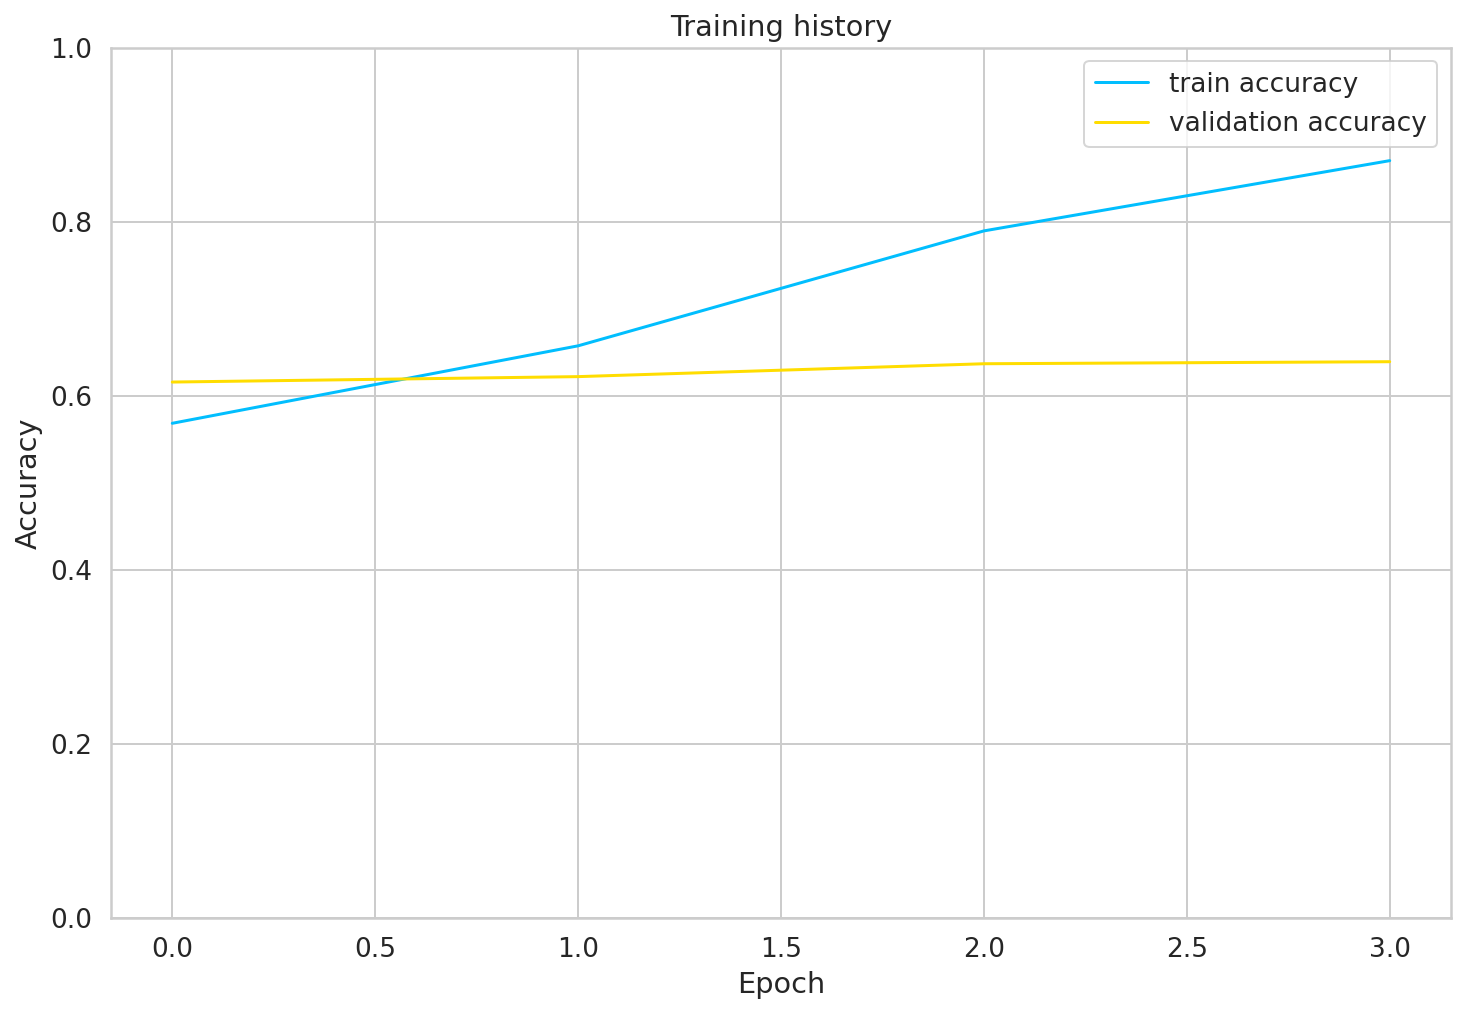

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);                                                                                                                                                                                                           

In [ ]:
url = 'https://raw.githubusercontent.com/srushtinandu/NLP-Project/main/data/test.tsv'
test_data = pd.read_csv(url, sep = '\t')
test_data.columns=['ID', 'Label', 'Statement', 'subject(s)', 'speaker', 'speaker\'s job', 'state info', 'party affiliation', 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts', 'context (venue / location of the speech or statement)']

In [ ]:
test_data = test_data.drop(columns=['ID', 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts'])
def to_label(label):
  if label == 'mostly-true' or label == 'half-true':
    return 'true'
  elif label == 'pants-fire' or label == 'barely-true':
    return 'false'
  else:
    return label
test_data['Label'] = test_data.Label.apply(to_label)
test_data.replace(['true', 'false'], [1,0], inplace=True)

In [ ]:
test_data_loader = create_data_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_data)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

0.6153238546603476

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  statement_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["statement_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      statement_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return statement_texts, predictions, prediction_probs, real_values

In [ ]:
y_statement_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        true       0.57      0.50      0.53       553
       false       0.64      0.71      0.67       713

    accuracy                           0.62      1266
   macro avg       0.61      0.60      0.60      1266
weighted avg       0.61      0.62      0.61      1266



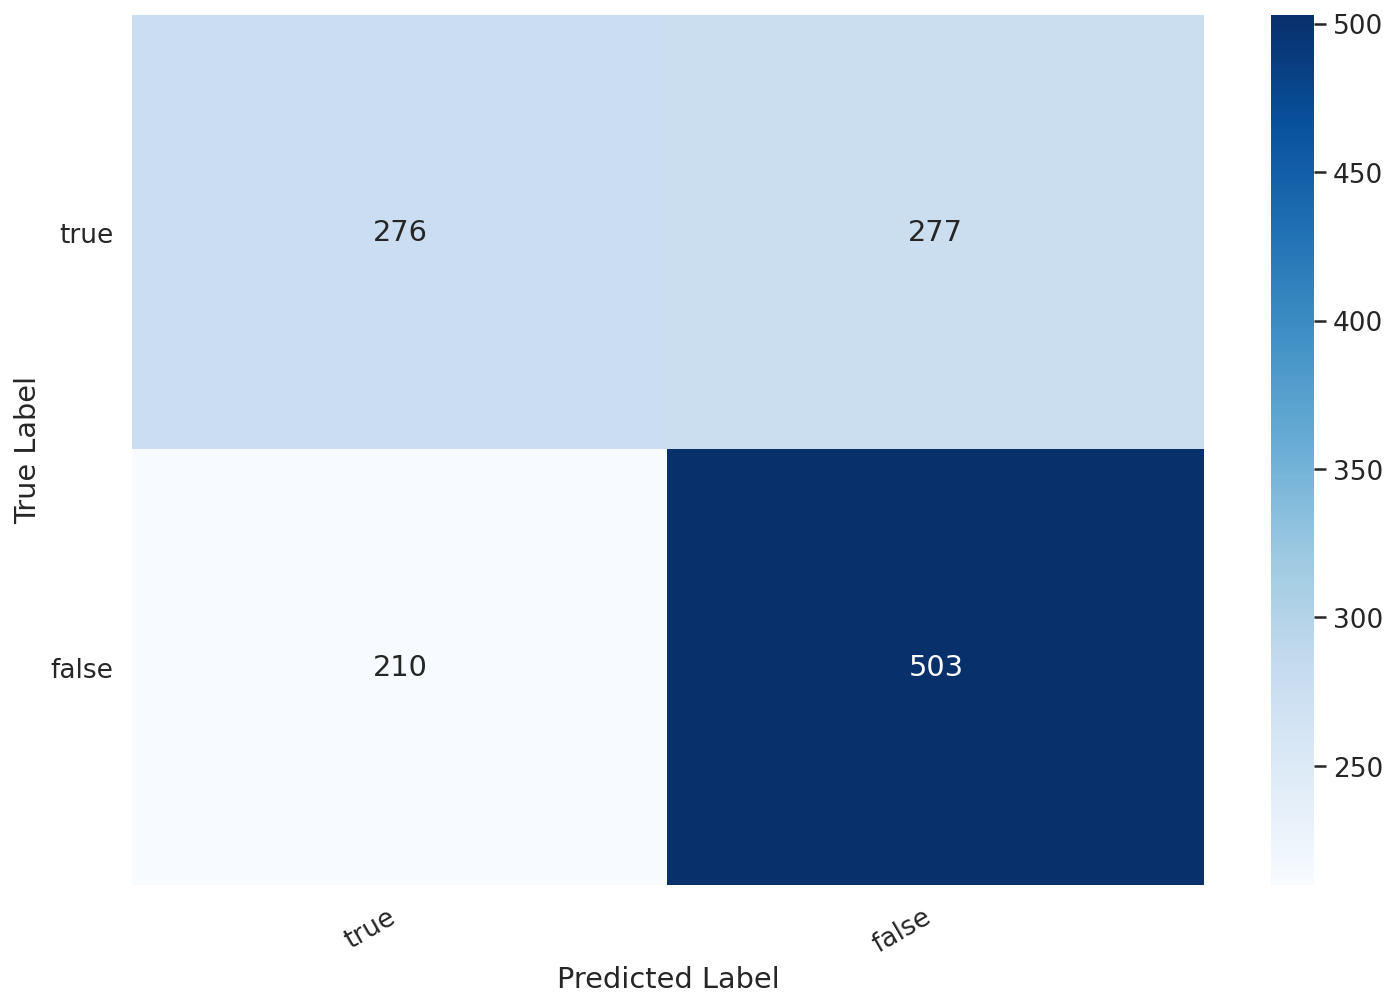

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)